# Filter fragments for unwanted substructures

## Aim of this notebook

This notebook aims to filter out fragments containing unwanted substructures, which could cause unwanted side effects. One class of unwanted substrctures are Pan Assay INterference compoundS ([PAINS](https://pubs.acs.org/doi/abs/10.1021/jm901137j)), which are included in the [rdkit Filter Catalog](https://www.rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html).
Also filtering for unwanted substructures accoring to the list of [Brenk](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139).
            

## Table of contents
* 1. Load fragment library
* 2. Apply pre-filters
* 3. Filter using PAINS substructures
* 4. Filter using Brenk list
* 5. Analyse accepted/rejected fragments

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
from rdkit.Chem import PandasTools

from kinfraglib import utils
from kinfraglib import filters

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

## Globals

In [4]:
# Path to data
HERE = Path(_dh[-1])
PATH_DATA = HERE / '../../data'

## 1. Load fragment library

In [5]:
fragment_library = utils.read_fragment_library(PATH_DATA / 'fragment_library')

In [6]:
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [7]:
pd.concat(fragment_library).reset_index(drop=True).shape

(7486, 15)

## 2. Apply pre-filters
Pre-filters are
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [8]:
fragment_library_pre_filtered = filters.prefilters.pre_filters(fragment_library)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]"
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]"
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE]
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]"
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]"

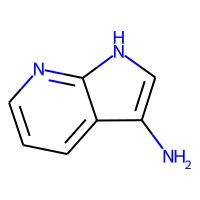
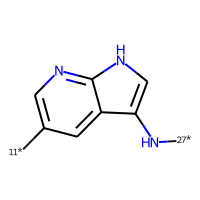
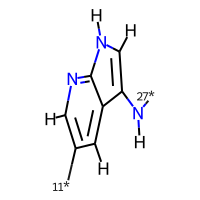
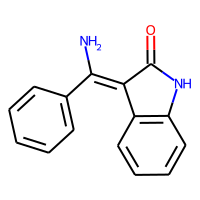
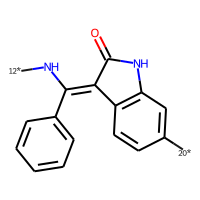
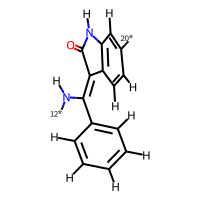
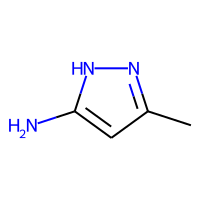
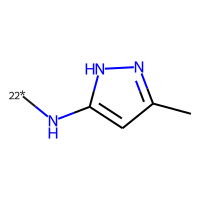
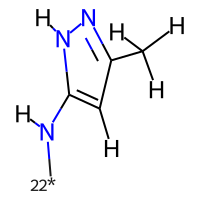
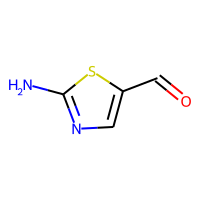
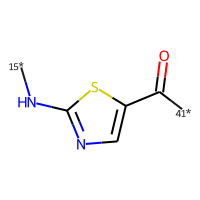
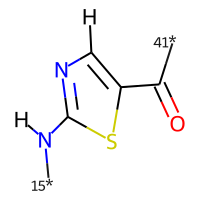
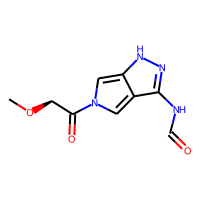
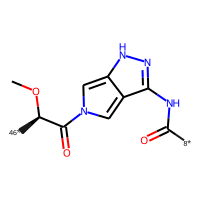
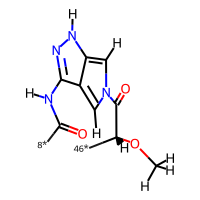

In [9]:
fragment_library_pre_filtered['AP'].head()

In [10]:
pd.concat([filters.analysis.count_fragments(fragment_library,
                                            'original'),
           filters.analysis.count_fragments(fragment_library_pre_filtered,
                                            'pre_filtered')],
          axis=1)

,original,pre_filtered
subpocket,,
AP,2561,1001
FP,1866,862
SE,1560,606
GA,1024,306
B1,98,42
B2,92,42


For further use we save fragment_library as fragment_library_original and fragment_library_pre_filtered as fragment_library.

In [11]:
fragment_library_original = fragment_library.copy()
fragment_library = fragment_library_pre_filtered.copy()

## 3. Filter for PAINS substructures

Pan Assay INterference compunds [(PAINS)](https://doi.org/10.1021/jm901137j) are substructural features which help to detect compounds that appear as false positive hits in high throughput screenings as starting points for drug development.
            

In [12]:
pains_dict = filters.pains.get_pains(fragment_library)

In [13]:
accepted_fragments_pains = pains_dict["accepted_fragments"]
rejected_fragments_pains = pains_dict["rejected_fragments"]
fragment_library_unwanted_sub = pains_dict["fragment_library"]
pains_df = pains_dict["pains"]

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
fragment,,,,,,,,,,,...,,,,,,,,,,
pains,Imine_one_isatin(189),Imine_one_isatin(189),Imine_one_isatin(189),Quinone_a(370),Thio_ketone(43),Catechol_a(92),Quinone_a(370),Quinone_a(370),Quinone_a(370),Dyes5a(27),...,Anil_di_alk_a(478),Anil_no_alk(40),Anil_no_alk(40),Indol_3yl_alk(461),Catechol_a(92),Thiophene_hydroxy(28),Hzone_anil(14),Hzone_anil(14),Anil_no_alk(40),Thio_ketone(43)

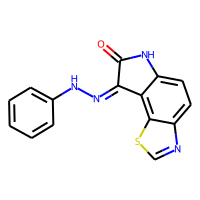
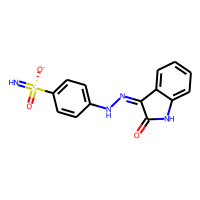
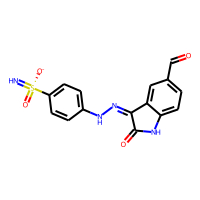
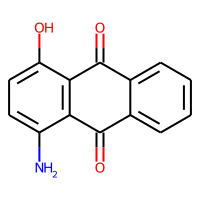
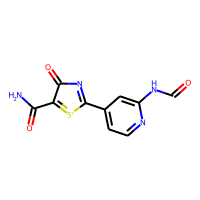
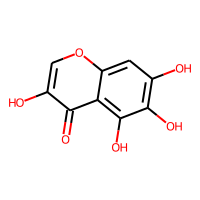
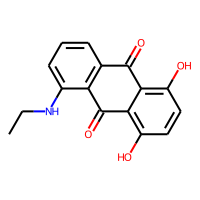
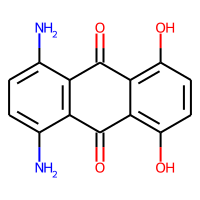
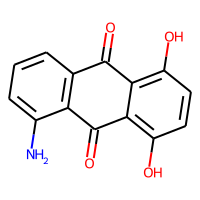
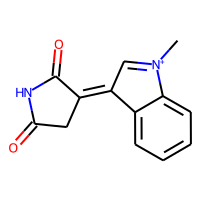
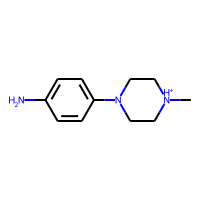
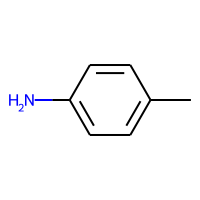
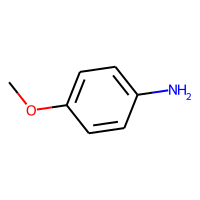
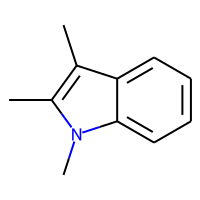
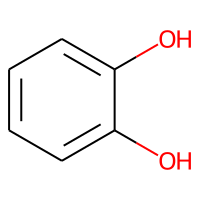
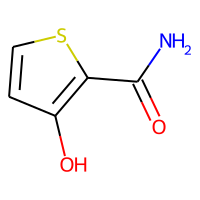
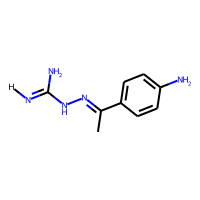
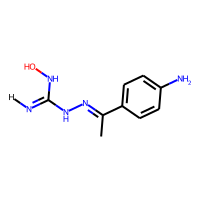
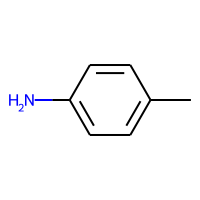
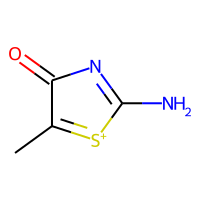

In [14]:
pains_df.T

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,O=C1Nc2ccc3ncsc3c2/C1=N/Nc1ccccc1,,,,CDK2,CDK,CMGC,1ke6,LS2,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,[30*]c1ccc(N/N=C2\C(=O)Nc3ccc4ncsc4c32)cc1,1,[SE],[AP=SE]
1,AP,N=[S@@](=O)([O-])c1ccc(N/N=C2\C(=O)Nc3ccccc32)cc1,,,,CDK2,CDK,CMGC,4fku,60K,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,[27*]c1ccc2c(c1)/C(=N/Nc1ccc([S@](=N)(=O)[O-])...,2,[GA],[AP=GA]
2,AP,N=[S@@](=O)([O-])c1ccc(N/N=C2\C(=O)Nc3ccc(C=O)...,,,,CDK2,CDK,CMGC,4fkv,61K,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 6 16 16 16 16 16 16 16...,[4*]C(=O)c1ccc2c(c1)/C(=N/Nc1ccc([S@](=N)(=O)[...,2,[FP],[AP=FP]
3,AP,Nc1ccc(O)c2c1C(=O)c1ccccc1C2=O,,,,CaMKK2,CAMKK,Other,5yv8,91L,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 1...,[1*]c1cc(O)c2c(c1N)C(=O)c1ccccc1C2=O,1,[GA],[AP=GA]
4,AP,NC(=O)C1=[S+]C(c2ccnc(NC=O)c2)=NC1=O,,,,GSK3B,GSK,CMGC,4ptc,2WE,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 5...,[19*]C(=O)Nc1cc(C2=NC(=O)C(C(N)=O)=[S+]2)ccn1,1,[SE],[AP=SE]

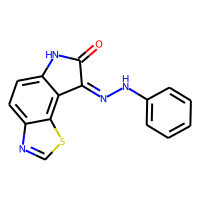
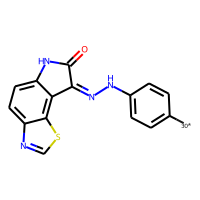
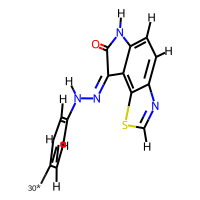
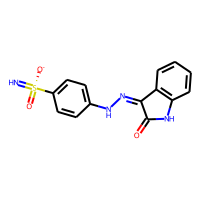
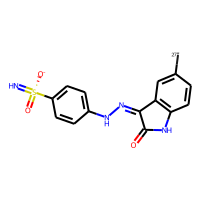
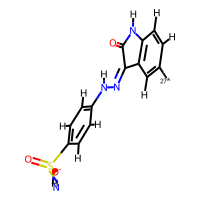
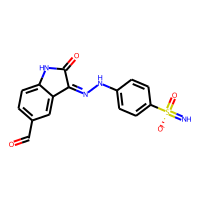
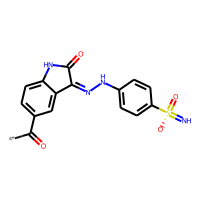
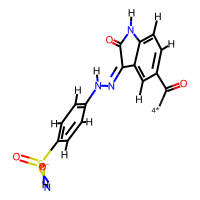
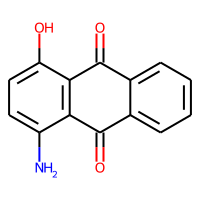
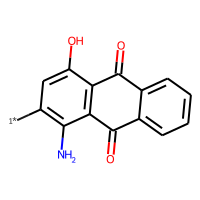
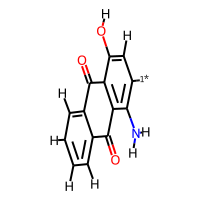
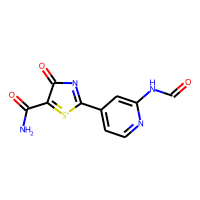
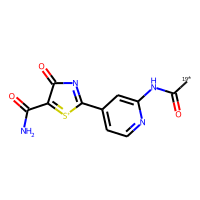
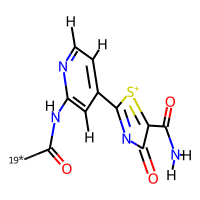

In [15]:
rejected_fragments_pains['AP'].head()

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]"
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]"
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE]
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]"
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]"

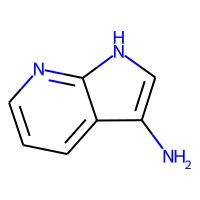
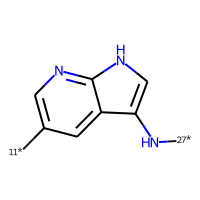
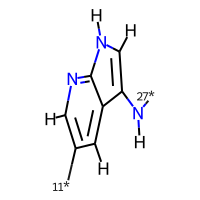
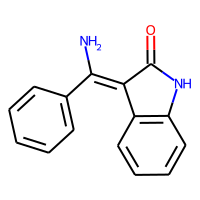
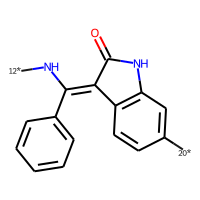
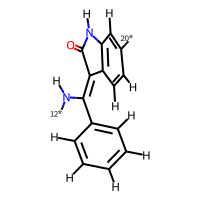
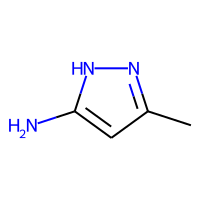
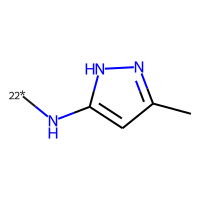
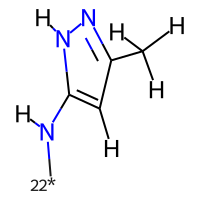
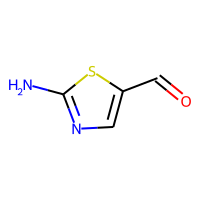
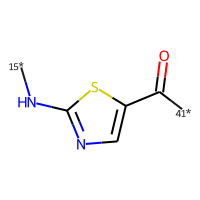
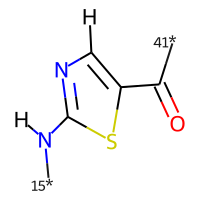
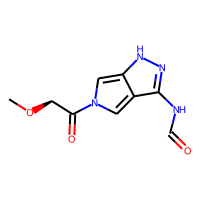
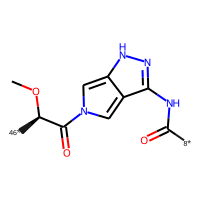
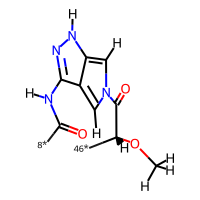

In [16]:
accepted_fragments_pains['AP'].head()

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_pains
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",1
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",1

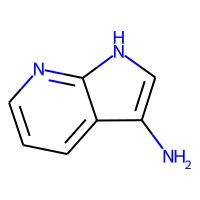
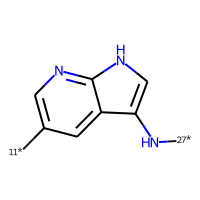
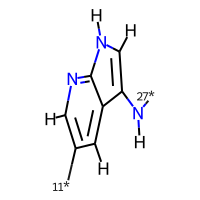
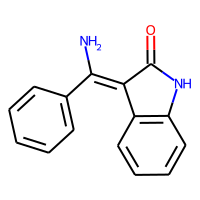
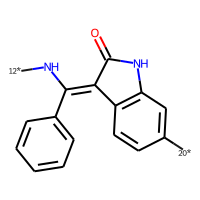
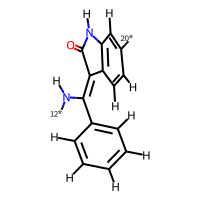
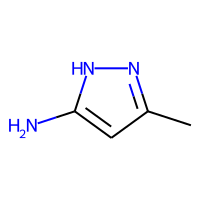
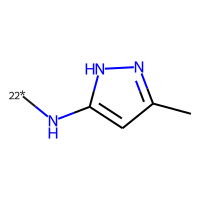
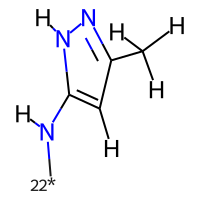
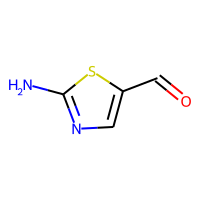
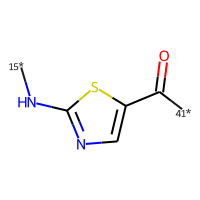
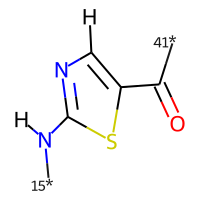
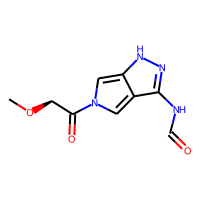
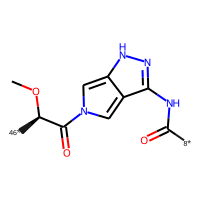
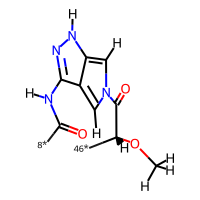

In [17]:
fragment_library_unwanted_sub['AP'].head()

In [18]:
pd.concat([filters.analysis.count_fragments(
    fragment_library,
    "pre_filtered"),
          filters.analysis.count_accepted_rejected(
              fragment_library_unwanted_sub,
              'bool_pains',
              'pains')],
          axis=1)

,pre_filtered,accepted_pains,rejected_pains
subpocket,,,
AP,1001,990,11.0
FP,862,845,17.0
SE,606,598,8.0
GA,306,300,6.0
B1,42,42,NaN
B2,42,42,NaN


## 4. Filter for substructures in Brenk

[Brenk et al.]( https://doi.org/10.1002/cmdc.200700139) defined a list of substructures which can be used as selection criteria to enrich libraries for lead-like compounds. Brenk et al. suggest to avoid using structures containing potentially mutagenic groups (e.g. nitro groups), groups with unfavorable pharmacokinetic properties (e.g. sulfates, phosphates), reactive groups (e.g. 2-halopyridines, thiols) and compounds interfering with typical HTS assays.         

In [19]:
HERE = Path(_dh[-1])
DATA =  HERE / '../../data/filters/Brenk'

In [20]:
brenk_dict = filters.unwanted_substructures.get_brenk(fragment_library_unwanted_sub, DATA)

Number of unwanted substructures in Brenk et al. collection: 104


In [21]:
not_brenk_df = brenk_dict['accepted_fragments']
brenk_df = brenk_dict['rejected_fragments']
fragment_library_unwanted_sub =  brenk_dict['fragment_library']
brenk_structs = brenk_dict['brenk']

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_pains,bool_brenk
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1,1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",1,0
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1,1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1,0
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",1,0

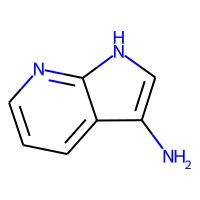
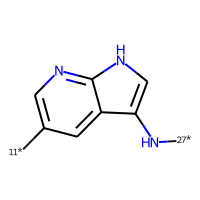
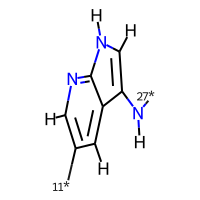
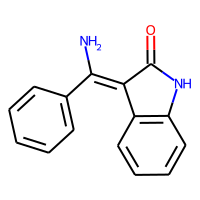
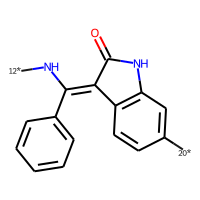
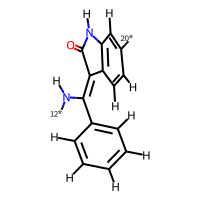
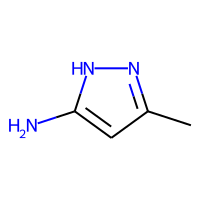
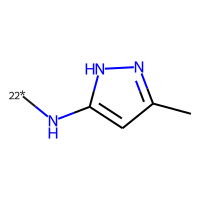
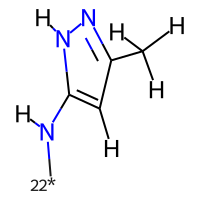
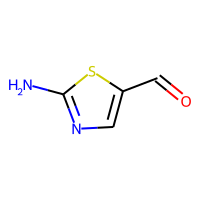
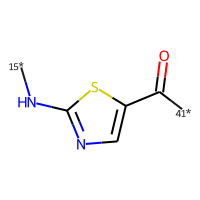
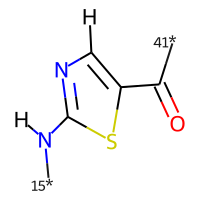
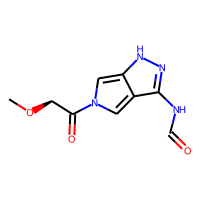
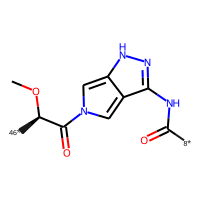
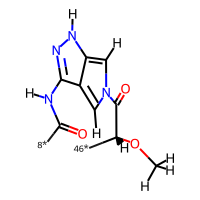

In [22]:
fragment_library_unwanted_sub['AP'].head()

In [23]:
pd.concat([filters.analysis.count_fragments(
    fragment_library,
    "pre_filtered"),
          filters.analysis.count_accepted_rejected(
              fragment_library_unwanted_sub,
              'bool_pains',
              'pains'),
          filters.analysis.count_accepted_rejected(
              fragment_library_unwanted_sub,
              'bool_brenk',
              'brenk')],
          axis=1)

,pre_filtered,accepted_pains,rejected_pains,accepted_brenk,rejected_brenk
subpocket,,,,,
AP,1001,990,11.0,782,219
FP,862,845,17.0,705,157
SE,606,598,8.0,496,110
GA,306,300,6.0,196,110
B1,42,42,NaN,26,16
B2,42,42,NaN,36,6


## 5. Analyse accepted/rejected fragments

In [24]:
fragment_library_unwanted_sub = filters.analysis.number_of_accepted(
    fragment_library_unwanted_sub, columns=['bool_pains', 'bool_brenk'],
    min_accepted=2)

In [25]:
pd.concat([filters.analysis.count_fragments(
    fragment_library_unwanted_sub,
    'pre_filtered'),
          filters.analysis.count_accepted_rejected(
              fragment_library_unwanted_sub,
              'bool', 'both')],
          axis=1)

,pre_filtered,accepted_both,rejected_both
subpocket,,,
AP,1001,781,220
FP,862,702,160
SE,606,494,112
GA,306,195,111
B1,42,26,16
B2,42,36,6
